> *Note: to run any cell in Jupyter notebook (this file) make sure you are in the cell you want to run and press Shift + Enter or **Run** at the top*

# Unsaturated flow in 2D

This tutorial deals with the usage of the **unsaturated_2Dflow** module to simulate/analyse 
the flow of water or chemical (or fluid in general) in a variably saturated matrix. The emphasis 
is not on the finite element implementation; rather it is on the preprocessor and description of how the 
code is run. 

<img src="http://mofem.eng.gla.ac.uk/mofem/html/flow_rec.gif" width="600">

The presentation includes:
- An overview of the mathematical equation
- The creation of the geometry and physical groups in Gmsh
- Meshing the geometry in Gmsh 
- Executing the code and parameter input arguments 
- Converting output into vtk
- Visualizing the output in paraView

## Unsaturated flow model

The mathematical equation describing the movement of water or chemicals in a variably 
saturated matrix is usually given by Richards' model, 
<!-- \cite{Vogel2001} -->

\begin{equation}
\frac{\partial \theta(h)}{\partial t} - \mathrm{div}\,[K(h)\,\mathrm{grad}\,(h - z)] = 0
\end{equation}

where $h$ is the pressure head, $\theta$ the water (chemical) content is a function of $h$. 
The hydraulic conductivity $K$ is positive definite. The variable $z$ refers to the 
vertical distance in the case of vertical flow against the action of gravitational 
force. However, when the flow is assumed to be restricted in the horizontal plane 
(i.e., $z$ is constant), the contribution of $z$ is ignored.   

A full description of the above model requires constitutive laws for the fluid content 
$\theta(h)$ and hydraulic conductivity $K(h)$, and boundary and initial conditions. These 
constitutive laws depend on the particular material (such as the matrix and the fluid) properties under consideration.

In this example, we consider the modified van Genuchten (MVG) constitutive laws. 
The volumetric fluid content constitutive equation is given as
\begin{equation} 
\theta(h) = \begin{cases} 
      \theta_r + \frac{\theta_m - \theta_r}{[1+(-\alpha h)^n]m}, & h < h_s\\
      \theta_s, & h\leq h_s
   \end{cases}
\end{equation}
where $\theta_r$ and $\theta_s$,are positive material parameters referred to as residual 
and saturated fluid contents. The parameter $h_s$ is the minimal capillary pressure, 
and $\theta_m$ is a fictitious modelling parameter.  $\alpha$ and $n$ are empirical 
shape parameters. In addition, the constitutive equation for the hydraulic conductivity is given by

\begin{equation} 
\theta(h) = \begin{cases} 
      K_s\,K_r(h), & h < h_s\\
      K_s, & h\leq h_s
   \end{cases}
\end{equation}
where $K_s$ is the saturated hydraulic conductivity and $K_r$ is the unsaturated hydraulic 
conductivity, which is related to $h$ through the effective saturation $S_e$ (volume fraction representing 
the composition of fluid in the matrix-fluid mixture) by
\begin{equation}
K_r = S_e^\ell \bigg[ \frac{1-F(S_e)}{1-F(1)}\bigg]^2
\end{equation}

where $\ell$ is the pore connectivity parameter usually assumed to be $0.5$, and the 
function $F$ is given by

\begin{equation}
F = \bigg[1-\bigg(\frac{\theta_s - \theta_r}{\theta_m - \theta_r}S_e\bigg)^{1/m}\bigg]^m
\end{equation}
and the effective saturation is given by
\begin{equation}
S_e = \frac{\theta - \theta_r}{\theta_s - \theta_r}
\end{equation}
Here $m = 1 - 1/n$, $n>1$.

The values of the parameters used in this problem represents $K_s = 1.0, \ell = 0.5, \theta_r = 0.045, 
\theta_s = 0.43, \theta_m = 0.43, n = 5.38, \alpha = 1.8125$ and $h_s = 0.00$.

The boundary conditions are divided into two (see Figure 1); one that prescribes the pressure 
head $h$ on a given part of the boundary $\Gamma_1$, the other one prescribes the flux on 
the rest of the boundary $\Gamma_2 = \partial\Omega - \Gamma_1$. Usually the second type of 
boundary condition is zero flux which corresponds to an insulation of the boundary, i.e., no 
material is coming in and out of the boundary.

The initial condition prescribes the pressure head $h$ at the beginning of the simulation, 
in this example we consider a homogeneous initial condition, i.e., $h = h_s$

## Creating the geometry
The problem considered in this tutorial is the lateral flow of a dissolvable fluid in a simple 
rectangular paper slide as shown in Figure 1. Part of the boundary labeled $\Gamma_1$ 
is in contact with a source of the fluid associated with pressure head $h = C$. The rest of the boundary, i.e., 
$\Gamma_2$, is insulated. 

<img src="http://mofem.eng.gla.ac.uk/mofem/html/domain.png" title="Figure 1: Domain and boundary decomposition" width="600">
<center>Figure 1: Domain and boundary decomposition</center>

The geometry of the paper slide $\Omega$ has been created in Gmsh, a open-source mesh generating software. Later, the 
geometry has been saved in to a .geo file that can be opened in any text editor, 
which in turn provides an alternative way of modifying it. 
 
A simple two step procedure to create this rectangular geometry is as follows: first open the Gmsh software, then go to 

`
File -> New -> Choose directory -> give name (e.g., paper_network.geo) -> save -> choose OpenCASCADE from the dialogue box
`

<img src="http://mofem.eng.gla.ac.uk/mofem/html/opencascade.png" width="800">

Next, on the left click on the **Module**; this opens three branches namely **Geometry**, **Mesh** and **Solver**, then follow

`
Geometry -> Elementary entities -> Add -> Rectangle  
`

A dialogue page appears as shown below, press "shift" key to hold position and enter X = 0, Y = 0, Z = 0 as the coordinates of 
the left corner of the rectangle and enter DX = 0.02 and DY = 0.005 as the dimensions, make sure that **radius rounded** is set to 0. 
Then click **Add** on the dialogue box.

<img src="http://mofem.eng.gla.ac.uk/mofem/html/creat_rect1.png" width="800">

 To finish creating the rectangle press "q" key to abort. Now the rectangle is created.

<img src="http://mofem.eng.gla.ac.uk/mofem/html/creat_rect2.png" width="800">


## Physical groups

Physical groups refers to regions in the domain where various values are prescribed, for example, boundary conditions, 
initial conditions, material parameters etc. For the problem under consideration, we only need two types of physical groups, initial 
and boundary conditions. Now go back to our rectangle in Gmesh. Note that every  **Point**, **Line** or **Plane** is allocated a unique ID by Gmsh 
as it is created, automatically. To view such ID's, under the **Tools** Menu choose **Options**, and in the dialogue box that appears
press on the **Geometry** menu on the left then under **Visibility** check **Curve labels** and **Surface labels** then close the dialogue box.

<img src="http://mofem.eng.gla.ac.uk/mofem/html/option_vis.png" width="800">

To create the boundary entity where pressure head $h$ is prescribed i.e., $\Gamma_1$ (Note that it is Line 4), follow

`
Module -> Geometry -> Physical groups -> Add -> Curve
`

 Give it a name on the dialogue box appearing, e.g., **ESSENTIAL**, uncheck **Automatic numbering** and enter 1 in the **Numer** field. Hover the 
 the cursor over the rectangle and Click on **Line 4** to select it (then its color is changed to red), and Press "e" to end selection and "q" to abort.

<img src="http://mofem.eng.gla.ac.uk/mofem/html/essential.png" width="800">

Next to choose the Physical Group where the initial condition is prescribed (in this case, only one initial condition which is prescribed over the entire
rectangle, i.e. Plane 1, is considered), follow  

`
Module -> Geometry -> Physical groups -> Add -> Surface
`

on the dialogue box give it a name, e.g., **INITIAL**. Select uncheck **Automatic numbering** and enter 2 on the **number** field, and the hover over the rectangle and 
select **Plane 1**, afterwards press "e" to end selection and "q" to abort.

<img src="http://mofem.eng.gla.ac.uk/mofem/html/initial.png" width="800">

This results in the file [**paper_network.geo**](paper_network.geo)

`
// Gmsh project created on Mon Jan 27 21:51:41 2020
SetFactory("OpenCASCADE");
Rectangle(1) = {0, 0, 0, 0.02, 0.005, 0};
Physical Curve("ESSENTIAL", 1) = {4};
Physical Surface("INITIAL", 2) = {1};
`

which you can open with any text editor from which you can modify the geometry, for example, for later use we can create variables lx and ly
for dimensions of the rectangle as follows

`
// Gmsh project created on Mon Jan 27 21:51:41 2020
SetFactory("OpenCASCADE");
lx = 0.02;
ly = 0.005;
Rectangle(1) = {0, 0, 0, 0.02, 0.005, 0};
Physical Curve("ESSENTIAL", 1) = {4};
Physical Surface("INITIAL", 2) = {1};
`

## Meshing 
Creating the mesh is simple, once we have the .geo file setup correctly, you load the modified **paper_network.geo** file 
as follows 

`
File -> Open... -> select the file you want to load (in this case is paper_network.geo)
`

Then to create the mesh,

`
Module -> Mesh -> 2D 
`

The rectangle is the meshed into relatively coarser triangles. If you want to refine it, just press **Refine by splitting** under 
**Mesh**. (you can repeat pressing it 
as many times as required, to get to an acceptable level of refinement.) 

<img src="http://mofem.eng.gla.ac.uk/mofem/html/mesh.png" width="800">

To save the resulting mesh you need to go to 

`
File -> Export -> select a folder you want to save in -> give it a name , e.g., paper_network.med -> save
`

Choose **Select all elements** for the MED Options, and press **OK**.

At this point, we have everything we need to run the programme. 
<!-- But there is one important ingredient that needs to be considered before we use the mesh 
in the MoFEM context. First, note that **.med** file is not directly used by MoFEM. To convert it to a mesh file readable by MoFEM, i.e., **.h5m** format, 
we need something referred to as a configuration file of **.cfg** format, which basically contains rules to convert the **Physical groups** from Gmsh into 
the corresponding NODESET, SIDESET and BLOCKSET that are understandable by MoFEM. For example, for the mesh generated above the configuration 
file [**bc.cfg**](bc.cfg) looks like 

`
[block_1] 
id=1001
add=BLOCKSET
name=ESSENTIAL`

`
[block_2]
id=1002
add=BLOCKSET
name=INITIAL
`

**Note:** it is very important that you need to make sure that each Physical Group with its ID matches the block in **bc.cfg**. This means that, 
for example, the physical group "ESSENTIAL" has been assigned ID 1 which should be corresponded by [block_1], id=1001, name=ESSENTIAL. Whereas, the 
Physical Group "INITIAL" with ID 2 should be matched by [block_2], id=1002, name=INITIAL. If there is any mismatch it leads to an entirely
wrong result. -->

## Upload mesh to Jupyter

To let this setup use the mesh you created, upload it to the following folder: http://127.0.0.1:8888/tree/um_view/softmech/unsaturated_2Dflow or wherever your working directory with **unsaturated_2Dflow** program is.

The **Upload** button is usually located in the top right corner next to **New** and bellow **Quit**. Unfortunately, some browsers do not support this function. If you have this issue, try to use a different browser for uploading the file (Chrome works).

# Running code

> *Reminder:* <br>
> - run cell with Shift + Enter <br>
> - if variable is manually changed, run the cell to update it

In [1]:
# set the variables
mesh_file_name = "paper_network.med"  # replace with the mesh file you'd like to work with
saturated_conductivity = "1.0" # set saturated_conductivity of the paper

In [2]:
# set directories
d_view = "/mofem_install/um_view/"
wd = d_view + "softmech/unsaturated_2Dflow"
toold = d_view + "bin"
# check if the working directory (wd) is set correctly
!cd {wd} && pwd  # check the working directory was set

/mofem_install/um_view/softmech/unsaturated_2Dflow


In [3]:
# read the .med file and check your BLOCKSETs
!cd {wd} && {toold}/read_med \
-med_file {mesh_file_name} \
-output_file paper_network_pre.h5m

[0] <inform> MoFEM version 0.10.1 (MOAB 5.2.1 Petsc Release Version 3.11.4, Sep, 28, 2019 )
[0] <inform> git commit id SHA1-NOT FOUND
[0] <inform> Local time: 2021-1-25 16:58:11
[0] <inform> UTC time: 2021-1-25 16:58:11
[0] <inform> [MedInterface] Reading MED file V4.0.0 using MED library V4.0.0
[0] <inform> [MedInterface] Check mesh paper_network nsteps 1
[0] <inform> [MedInterface] Reading mesh paper_network nsteps 1
[0] <inform> [MedInterface] Read number of nodes 48
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name paper_network
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name ESSENTIAL                      
[0] <inform> [read_med] meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name INITIAL                        


In [4]:
# partition the mesh before running analysis
!cd {wd} && {toold}/mofem_part \
-my_file paper_network_pre.h5m \
-output_file paper_network_final.h5m \
-my_nparts 1 -dim 2 -adj_dim 1

[0] <inform> MoFEM version 0.10.1 (MOAB 5.2.1 Petsc Release Version 3.11.4, Sep, 28, 2019 )
[0] <inform> git commit id SHA1-NOT FOUND
[0] <inform> Local time: 2021-1-25 16:58:12
[0] <inform> UTC time: 2021-1-25 16:58:12
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name paper_network
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name ESSENTIAL                      
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name INITIAL                        
[0] <inform> [mofem_part] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name paper_network
[0] <inform> [mofem_part] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name ESSENTIAL                      
[0] <inform> [mofem_part] meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name INITIAL                        
[0] <inform> [Prob

In [5]:
!rm {wd}/out_*   # remove previous analysis if present

# run the analysis on the prepared mesh
!cd {wd} && ./unsatu2dFlow_prob \
-file_name paper_network_final.h5m \
-saturated_conductivity {saturated_conductivity} 2>&1 | tee log

[0] <inform> MoFEM version 0.10.1 (MOAB 5.2.1 Petsc Release Version 3.11.4, Sep, 28, 2019 )
[0] <inform> git commit id SHA1-NOT FOUND
[0] <inform> Local time: 2021-1-25 16:58:12
[0] <inform> UTC time: 2021-1-25 16:58:12
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name paper_network
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name ESSENTIAL                      
[0] <inform> [MeshsetsManager] read cubit meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name INITIAL                        
[0] <inform> [FieldCore] Add field h1 field_id 1 space H1 approximation base AINSWORTH_LEGENDRE_BASE rank 1 meshset 12682136550675316741
[0] <inform> [FECore] Add finite element dFE
[0] <inform> [FECore] Add finite element bFE
[0] <inform> [ProblemCore] Add problem SimpleProblem
[0] <inform> [FieldCore] Number of dofs 48
[0] <inform> [FECore] Finite element dFE added. Nb. 

[0] <inform> [petsc]     1 SNES Function norm 1.371043959086e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.454798528661e-03 
[0] <inform> [petsc]     3 SNES Function norm 1.208082572896e-04 
[0] <inform> [petsc]     4 SNES Function norm 1.511867364527e-05 
[0] <inform> [petsc]     5 SNES Function norm 1.475911436317e-06 
[0] <inform> [petsc]     6 SNES Function norm 1.792721025327e-07 
[0] <inform> [petsc]     7 SNES Function norm 1.906989122556e-08 
[0] <inform> [petsc] 13 TS dt 5e-07 time 6.5e-06
[0] <inform> [petsc]     0 SNES Function norm 3.242065233452e-01 
[0] <inform> [petsc]     1 SNES Function norm 1.423792885865e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.641365068015e-03 
[0] <inform> [petsc]     3 SNES Function norm 1.409032001894e-04 
[0] <inform> [petsc]     4 SNES Function norm 1.706420179516e-05 
[0] <inform> [petsc]     5 SNES Function norm 1.633283690318e-06 
[0] <inform> [petsc]     6 SNES Function norm 1.911565886363e-07 
[0] <inform> [petsc]     7 

[0] <inform> [petsc]     4 SNES Function norm 9.359780757953e-07 
[0] <inform> [petsc]     5 SNES Function norm 5.383088881341e-08 
[0] <inform> [petsc] 34 TS dt 5e-07 time 1.7e-05
[0] <inform> [petsc]     0 SNES Function norm 1.915647295434e-01 
[0] <inform> [petsc]     1 SNES Function norm 5.857709289485e-03 
[0] <inform> [petsc]     2 SNES Function norm 3.160107165717e-04 
[0] <inform> [petsc]     3 SNES Function norm 1.538263353240e-05 
[0] <inform> [petsc]     4 SNES Function norm 1.046143869991e-06 
[0] <inform> [petsc]     5 SNES Function norm 6.347079636656e-08 
[0] <inform> [petsc] 35 TS dt 5e-07 time 1.75e-05
[0] <inform> [petsc]     0 SNES Function norm 1.870039174115e-01 
[0] <inform> [petsc]     1 SNES Function norm 5.457990501229e-03 
[0] <inform> [petsc]     2 SNES Function norm 3.138636598078e-04 
[0] <inform> [petsc]     3 SNES Function norm 1.615295088935e-05 
[0] <inform> [petsc]     4 SNES Function norm 1.103499819840e-06 
[0] <inform> [petsc]     5 SNES Function no

[0] <inform> [petsc]     2 SNES Function norm 2.762557439186e-04 
[0] <inform> [petsc]     3 SNES Function norm 1.322125319556e-05 
[0] <inform> [petsc]     4 SNES Function norm 7.015300768932e-07 
[0] <inform> [petsc]     5 SNES Function norm 3.615923000025e-08 
[0] <inform> [petsc] 53 TS dt 5e-07 time 2.65e-05
[0] <inform> [petsc]     0 SNES Function norm 1.399626332525e-01 
[0] <inform> [petsc]     1 SNES Function norm 5.387644823346e-03 
[0] <inform> [petsc]     2 SNES Function norm 2.792975584675e-04 
[0] <inform> [petsc]     3 SNES Function norm 1.344114260492e-05 
[0] <inform> [petsc]     4 SNES Function norm 7.141136642820e-07 
[0] <inform> [petsc]     5 SNES Function norm 3.724749681863e-08 
[0] <inform> [petsc] 54 TS dt 5e-07 time 2.7e-05
[0] <inform> [petsc]     0 SNES Function norm 1.402407613375e-01 
[0] <inform> [petsc]     1 SNES Function norm 5.428820925971e-03 
[0] <inform> [petsc]     2 SNES Function norm 2.745435821695e-04 
[0] <inform> [petsc]     3 SNES Function no

[0] <inform> [petsc]     5 SNES Function norm 6.374567750104e-09 
[0] <inform> [petsc] 72 TS dt 5e-07 time 3.6e-05
[0] <inform> [petsc]     0 SNES Function norm 1.169834394997e-01 
[0] <inform> [petsc]     1 SNES Function norm 2.144715794924e-03 
[0] <inform> [petsc]     2 SNES Function norm 9.040712992394e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.357011991503e-06 
[0] <inform> [petsc]     4 SNES Function norm 1.440244601209e-07 
[0] <inform> [petsc]     5 SNES Function norm 5.765904877857e-09 
[0] <inform> [petsc] 73 TS dt 5e-07 time 3.65e-05
[0] <inform> [petsc]     0 SNES Function norm 1.147371978461e-01 
[0] <inform> [petsc]     1 SNES Function norm 2.144423590441e-03 
[0] <inform> [petsc]     2 SNES Function norm 8.805918450285e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.126059928457e-06 
[0] <inform> [petsc]     4 SNES Function norm 1.294741185082e-07 
[0] <inform> [petsc]     5 SNES Function norm 4.967660116659e-09 
[0] <inform> [petsc] 74 TS dt 5e-07 time 3.

[0] <inform> [petsc]     0 SNES Function norm 1.023204492632e-01 
[0] <inform> [petsc]     1 SNES Function norm 2.731047946683e-03 
[0] <inform> [petsc]     2 SNES Function norm 9.632262252133e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.174143724674e-06 
[0] <inform> [petsc]     4 SNES Function norm 1.108175361368e-07 
[0] <inform> [petsc]     5 SNES Function norm 3.802460565478e-09 
[0] <inform> [petsc] 93 TS dt 5e-07 time 4.65e-05
[0] <inform> [petsc]     0 SNES Function norm 1.026431920801e-01 
[0] <inform> [petsc]     1 SNES Function norm 2.716552969268e-03 
[0] <inform> [petsc]     2 SNES Function norm 9.272722169077e-05 
[0] <inform> [petsc]     3 SNES Function norm 2.955155138459e-06 
[0] <inform> [petsc]     4 SNES Function norm 9.981142385257e-08 
[0] <inform> [petsc] 94 TS dt 5e-07 time 4.7e-05
[0] <inform> [petsc]     0 SNES Function norm 1.029302858783e-01 
[0] <inform> [petsc]     1 SNES Function norm 2.676992527934e-03 
[0] <inform> [petsc]     2 SNES Function no

[0] <inform> [petsc]     4 SNES Function norm 3.404187856243e-08 
[0] <inform> [petsc] 114 TS dt 5e-07 time 5.7e-05
[0] <inform> [petsc]     0 SNES Function norm 8.981149698599e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.156695604420e-03 
[0] <inform> [petsc]     2 SNES Function norm 3.483158113247e-05 
[0] <inform> [petsc]     3 SNES Function norm 1.032995592733e-06 
[0] <inform> [petsc]     4 SNES Function norm 3.329224088284e-08 
[0] <inform> [petsc] 115 TS dt 5e-07 time 5.75e-05
[0] <inform> [petsc]     0 SNES Function norm 8.862443844603e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.156643186283e-03 
[0] <inform> [petsc]     2 SNES Function norm 3.471263644475e-05 
[0] <inform> [petsc]     3 SNES Function norm 1.006407872619e-06 
[0] <inform> [petsc]     4 SNES Function norm 3.173980210152e-08 
[0] <inform> [petsc] 116 TS dt 5e-07 time 5.8e-05
[0] <inform> [petsc]     0 SNES Function norm 8.747709573856e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.154527161

[0] <inform> [petsc]     3 SNES Function norm 1.101050271552e-06 
[0] <inform> [petsc]     4 SNES Function norm 3.081826600407e-08 
[0] <inform> [petsc] 137 TS dt 5e-07 time 6.85e-05
[0] <inform> [petsc]     0 SNES Function norm 7.902882154943e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.505995218405e-03 
[0] <inform> [petsc]     2 SNES Function norm 4.190118277993e-05 
[0] <inform> [petsc]     3 SNES Function norm 1.112408482853e-06 
[0] <inform> [petsc]     4 SNES Function norm 3.092702233521e-08 
[0] <inform> [petsc] 138 TS dt 5e-07 time 6.9e-05
[0] <inform> [petsc]     0 SNES Function norm 7.920654742493e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.527470602258e-03 
[0] <inform> [petsc]     2 SNES Function norm 4.209600750067e-05 
[0] <inform> [petsc]     3 SNES Function norm 1.106368774624e-06 
[0] <inform> [petsc]     4 SNES Function norm 3.040801202925e-08 
[0] <inform> [petsc] 139 TS dt 5e-07 time 6.95e-05
[0] <inform> [petsc]     0 SNES Function norm 7.93899136

[0] <inform> [petsc]     1 SNES Function norm 8.066256731554e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.367449116564e-05 
[0] <inform> [petsc]     3 SNES Function norm 2.739789968945e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.463748275464e-09 
[0] <inform> [petsc] 160 TS dt 5e-07 time 8e-05
[0] <inform> [petsc]     0 SNES Function norm 7.512514513228e-02 
[0] <inform> [petsc]     1 SNES Function norm 7.856461896450e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.400039162556e-05 
[0] <inform> [petsc]     3 SNES Function norm 2.960967862283e-07 
[0] <inform> [petsc]     4 SNES Function norm 7.186280991330e-09 
[0] <inform> [petsc] 161 TS dt 5e-07 time 8.05e-05
[0] <inform> [petsc]     0 SNES Function norm 7.447379614266e-02 
[0] <inform> [petsc]     1 SNES Function norm 7.698629875294e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.442539180893e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.180646008252e-07 
[0] <inform> [petsc]     4 SNES Function no

[0] <inform> [petsc]     3 SNES Function norm 3.025964654560e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.424261886683e-09 
[0] <inform> [petsc] 182 TS dt 5e-07 time 9.1e-05
[0] <inform> [petsc]     0 SNES Function norm 6.415650486574e-02 
[0] <inform> [petsc]     1 SNES Function norm 7.643141515333e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.553568734118e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.110487039794e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.675046527143e-09 
[0] <inform> [petsc] 183 TS dt 5e-07 time 9.15e-05
[0] <inform> [petsc]     0 SNES Function norm 6.398369136717e-02 
[0] <inform> [petsc]     1 SNES Function norm 7.718234731109e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.581247544021e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.203497552965e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.931614261593e-09 
[0] <inform> [petsc] 184 TS dt 5e-07 time 9.2e-05
[0] <inform> [petsc]     0 SNES Function norm 6.383906994

[0] <inform> [petsc] 204 TS dt 5e-07 time 0.000102
[0] <inform> [petsc]     0 SNES Function norm 6.379127284006e-02 
[0] <inform> [petsc]     1 SNES Function norm 8.696535886391e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.691987681564e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.282685461484e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.673387600988e-09 
[0] <inform> [petsc] 205 TS dt 5e-07 time 0.0001025
[0] <inform> [petsc]     0 SNES Function norm 6.373678079527e-02 
[0] <inform> [petsc]     1 SNES Function norm 8.551925053113e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.631632915265e-05 
[0] <inform> [petsc]     3 SNES Function norm 3.106468975958e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.202975284070e-09 
[0] <inform> [petsc] 206 TS dt 5e-07 time 0.000103
[0] <inform> [petsc]     0 SNES Function norm 6.366112498377e-02 
[0] <inform> [petsc]     1 SNES Function norm 8.390147244349e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.567182

[0] <inform> [petsc]     4 SNES Function norm 3.242571986821e-09 
[0] <inform> [petsc] 226 TS dt 5e-07 time 0.000113
[0] <inform> [petsc]     0 SNES Function norm 5.812001121114e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.372468486367e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.870219380266e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.652875427271e-07 
[0] <inform> [petsc]     4 SNES Function norm 3.323025928644e-09 
[0] <inform> [petsc] 227 TS dt 5e-07 time 0.0001135
[0] <inform> [petsc]     0 SNES Function norm 5.775878044795e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.348747594570e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.958028062613e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.678889676124e-07 
[0] <inform> [petsc]     4 SNES Function norm 3.375071561804e-09 
[0] <inform> [petsc] 228 TS dt 5e-07 time 0.000114
[0] <inform> [petsc]     0 SNES Function norm 5.740480837385e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.333878

[0] <inform> [petsc]     0 SNES Function norm 5.315132550196e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.431010795154e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.044517959485e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.201688506256e-07 
[0] <inform> [petsc]     4 SNES Function norm 1.908660385060e-09 
[0] <inform> [petsc] 249 TS dt 5e-07 time 0.0001245
[0] <inform> [petsc]     0 SNES Function norm 5.308159120328e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.450188614340e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.027151579305e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.193461336097e-07 
[0] <inform> [petsc]     4 SNES Function norm 1.885280231705e-09 
[0] <inform> [petsc] 250 TS dt 5e-07 time 0.000125
[0] <inform> [petsc]     0 SNES Function norm 5.302245190070e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.471779634408e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.009332684058e-06 
[0] <inform> [petsc]     3 SNES Functio

[0] <inform> [petsc]     2 SNES Function norm 7.319566150581e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.425208291337e-08 
[0] <inform> [petsc] 273 TS dt 5e-07 time 0.0001365
[0] <inform> [petsc]     0 SNES Function norm 5.282470719216e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.760508462722e-04 
[0] <inform> [petsc]     2 SNES Function norm 7.229082672584e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.267879088947e-08 
[0] <inform> [petsc] 274 TS dt 5e-07 time 0.000137
[0] <inform> [petsc]     0 SNES Function norm 5.278005143733e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.716176838263e-04 
[0] <inform> [petsc]     2 SNES Function norm 7.126470232097e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.082578806848e-08 
[0] <inform> [petsc] 275 TS dt 5e-07 time 0.0001375
[0] <inform> [petsc]     0 SNES Function norm 5.272629181588e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.665053451891e-04 
[0] <inform> [petsc]     2 SNES Function norm 7.01241

[0] <inform> [petsc]     1 SNES Function norm 3.853016441299e-04 
[0] <inform> [petsc]     2 SNES Function norm 5.753380566851e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.571297876424e-08 
[0] <inform> [petsc] 301 TS dt 5e-07 time 0.0001505
[0] <inform> [petsc]     0 SNES Function norm 4.848949879031e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.817265853574e-04 
[0] <inform> [petsc]     2 SNES Function norm 5.836876364994e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.913512083921e-08 
[0] <inform> [petsc] 302 TS dt 5e-07 time 0.000151
[0] <inform> [petsc]     0 SNES Function norm 4.828534373051e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.784826298047e-04 
[0] <inform> [petsc]     2 SNES Function norm 5.918465472218e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.023921224935e-07 
[0] <inform> [petsc]     4 SNES Function norm 1.869648772589e-09 
[0] <inform> [petsc] 303 TS dt 5e-07 time 0.0001515
[0] <inform> [petsc]     0 SNES Function norm 4.80850

[0] <inform> [petsc]     3 SNES Function norm 1.617000842816e-07 
[0] <inform> [petsc]     4 SNES Function norm 3.464719453232e-09 
[0] <inform> [petsc] 324 TS dt 5e-07 time 0.000162
[0] <inform> [petsc]     0 SNES Function norm 4.540177793620e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.672321303491e-04 
[0] <inform> [petsc]     2 SNES Function norm 7.751839944807e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.672326435511e-07 
[0] <inform> [petsc]     4 SNES Function norm 3.630761439197e-09 
[0] <inform> [petsc] 325 TS dt 5e-07 time 0.0001625
[0] <inform> [petsc]     0 SNES Function norm 4.535360875430e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.700201942787e-04 
[0] <inform> [petsc]     2 SNES Function norm 7.915762144454e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.729243329011e-07 
[0] <inform> [petsc]     4 SNES Function norm 3.801165383986e-09 
[0] <inform> [petsc] 326 TS dt 5e-07 time 0.000163
[0] <inform> [petsc]     0 SNES Function norm 4.531172

[0] <inform> [petsc]     3 SNES Function norm 2.292061725442e-07 
[0] <inform> [petsc]     4 SNES Function norm 5.409783403265e-09 
[0] <inform> [petsc] 346 TS dt 5e-07 time 0.000173
[0] <inform> [petsc]     0 SNES Function norm 4.515652285669e-02 
[0] <inform> [petsc]     1 SNES Function norm 4.234575948318e-04 
[0] <inform> [petsc]     2 SNES Function norm 9.693710325456e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.248963181786e-07 
[0] <inform> [petsc]     4 SNES Function norm 5.269742564335e-09 
[0] <inform> [petsc] 347 TS dt 5e-07 time 0.0001735
[0] <inform> [petsc]     0 SNES Function norm 4.514303941834e-02 
[0] <inform> [petsc]     1 SNES Function norm 4.224373771371e-04 
[0] <inform> [petsc]     2 SNES Function norm 9.563336074889e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.196540003097e-07 
[0] <inform> [petsc]     4 SNES Function norm 5.100858033844e-09 
[0] <inform> [petsc] 348 TS dt 5e-07 time 0.000174
[0] <inform> [petsc]     0 SNES Function norm 4.512508

[0] <inform> [petsc]     1 SNES Function norm 3.107331403648e-04 
[0] <inform> [petsc]     2 SNES Function norm 2.335787493899e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.889057930156e-08 
[0] <inform> [petsc] 371 TS dt 5e-07 time 0.0001855
[0] <inform> [petsc]     0 SNES Function norm 4.291502976921e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.053442003402e-04 
[0] <inform> [petsc]     2 SNES Function norm 2.049964234721e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.575702461806e-08 
[0] <inform> [petsc] 372 TS dt 5e-07 time 0.000186
[0] <inform> [petsc]     0 SNES Function norm 4.274273204313e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.001556405410e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.790321236189e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.365364528089e-08 
[0] <inform> [petsc] 373 TS dt 5e-07 time 0.0001865
[0] <inform> [petsc]     0 SNES Function norm 4.256627007825e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.95180

[0] <inform> [petsc]     1 SNES Function norm 2.460753599039e-04 
[0] <inform> [petsc]     2 SNES Function norm 4.315195456026e-06 
[0] <inform> [petsc]     3 SNES Function norm 8.863785803515e-08 
[0] <inform> [petsc] 397 TS dt 5e-07 time 0.0001985
[0] <inform> [petsc]     0 SNES Function norm 3.822121199620e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.470218748289e-04 
[0] <inform> [petsc]     2 SNES Function norm 4.515082405438e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.567691304540e-08 
[0] <inform> [petsc] 398 TS dt 5e-07 time 0.000199
[0] <inform> [petsc]     0 SNES Function norm 3.807502594235e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.482208251652e-04 
[0] <inform> [petsc]     2 SNES Function norm 4.720266357618e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.030669369329e-07 
[0] <inform> [petsc]     4 SNES Function norm 2.430242049434e-09 
[0] <inform> [petsc] 399 TS dt 5e-07 time 0.0001995
[0] <inform> [petsc]     0 SNES Function norm 3.79336

[0] <inform> [petsc]     2 SNES Function norm 8.476132614885e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.657190737381e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.579136235318e-09 
[0] <inform> [petsc] 421 TS dt 5e-07 time 0.0002105
[0] <inform> [petsc]     0 SNES Function norm 3.581161301722e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.763342914389e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.506143627084e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.680355728409e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.682967038660e-09 
[0] <inform> [petsc] 422 TS dt 5e-07 time 0.000211
[0] <inform> [petsc]     0 SNES Function norm 3.573619470994e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.747547211389e-04 
[0] <inform> [petsc]     2 SNES Function norm 8.520497006242e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.697273910518e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.762473423351e-09 
[0] <inform> [petsc] 423 TS dt 5e-07 ti

[0] <inform> [petsc]     4 SNES Function norm 7.594129864155e-09 
[0] <inform> [petsc] 444 TS dt 5e-07 time 0.000222
[0] <inform> [petsc]     0 SNES Function norm 3.355129827453e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.143291864470e-04 
[0] <inform> [petsc]     2 SNES Function norm 6.969732522773e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.274128451224e-07 
[0] <inform> [petsc]     4 SNES Function norm 7.520657286459e-09 
[0] <inform> [petsc] 445 TS dt 5e-07 time 0.0002225
[0] <inform> [petsc]     0 SNES Function norm 3.343084063085e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.138389440447e-04 
[0] <inform> [petsc]     2 SNES Function norm 6.928179267854e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.255393222392e-07 
[0] <inform> [petsc]     4 SNES Function norm 7.452949510588e-09 
[0] <inform> [petsc] 446 TS dt 5e-07 time 0.000223
[0] <inform> [petsc]     0 SNES Function norm 3.331054825520e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.138024

[0] <inform> [petsc]     2 SNES Function norm 8.994740135612e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.766995402261e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.735512181929e-09 
[0] <inform> [petsc] 472 TS dt 5e-07 time 0.000236
[0] <inform> [petsc]     0 SNES Function norm 3.139041482244e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.968002704858e-04 
[0] <inform> [petsc]     2 SNES Function norm 9.071103294469e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.796255074018e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.841507864374e-09 
[0] <inform> [petsc] 473 TS dt 5e-07 time 0.0002365
[0] <inform> [petsc]     0 SNES Function norm 3.138592593073e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.983115243028e-04 
[0] <inform> [petsc]     2 SNES Function norm 9.136685753115e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.822962421528e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.941807263705e-09 
[0] <inform> [petsc] 474 TS dt 5e-07 ti

[0] <inform> [petsc]     2 SNES Function norm 5.432830591188e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.865054935232e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.459809325706e-09 
[0] <inform> [petsc] 501 TS dt 5e-07 time 0.0002505
[0] <inform> [petsc]     0 SNES Function norm 3.200107035377e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.501027806795e-04 
[0] <inform> [petsc]     2 SNES Function norm 5.131862353618e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.768016172576e-07 
[0] <inform> [petsc]     4 SNES Function norm 6.143240520319e-09 
[0] <inform> [petsc] 502 TS dt 5e-07 time 0.000251
[0] <inform> [petsc]     0 SNES Function norm 3.200208433615e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.408875532298e-04 
[0] <inform> [petsc]     2 SNES Function norm 4.831457393412e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.669990145144e-07 
[0] <inform> [petsc]     4 SNES Function norm 5.819910269012e-09 
[0] <inform> [petsc] 503 TS dt 5e-07 ti

[0] <inform> [petsc]     4 SNES Function norm 7.015432550202e-09 
[0] <inform> [petsc] 524 TS dt 5e-07 time 0.000262
[0] <inform> [petsc]     0 SNES Function norm 3.109827384736e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.382019615957e-04 
[0] <inform> [petsc]     2 SNES Function norm 5.194223141702e-06 
[0] <inform> [petsc]     3 SNES Function norm 1.971391926314e-07 
[0] <inform> [petsc]     4 SNES Function norm 7.514369701491e-09 
[0] <inform> [petsc] 525 TS dt 5e-07 time 0.0002625
[0] <inform> [petsc]     0 SNES Function norm 3.102155199480e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.454011589788e-04 
[0] <inform> [petsc]     2 SNES Function norm 5.494497190018e-06 
[0] <inform> [petsc]     3 SNES Function norm 2.095941341006e-07 
[0] <inform> [petsc]     4 SNES Function norm 8.026851914724e-09 
[0] <inform> [petsc] 526 TS dt 5e-07 time 0.000263
[0] <inform> [petsc]     0 SNES Function norm 3.094249928255e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.526414

[0] <inform> [petsc]     2 SNES Function norm 1.245162434007e-05 
[0] <inform> [petsc]     3 SNES Function norm 5.309393637983e-07 
[0] <inform> [petsc]     4 SNES Function norm 2.267187086781e-08 
[0] <inform> [petsc] 547 TS dt 5e-07 time 0.0002735
[0] <inform> [petsc]     0 SNES Function norm 2.888952182720e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.017972733250e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.284030134267e-05 
[0] <inform> [petsc]     3 SNES Function norm 5.513181978143e-07 
[0] <inform> [petsc]     4 SNES Function norm 2.370507483805e-08 
[0] <inform> [petsc] 548 TS dt 5e-07 time 0.000274
[0] <inform> [petsc]     0 SNES Function norm 2.877827876952e-02 
[0] <inform> [petsc]     1 SNES Function norm 3.089828439605e-04 
[0] <inform> [petsc]     2 SNES Function norm 1.323911229908e-05 
[0] <inform> [petsc]     3 SNES Function norm 5.725354652629e-07 
[0] <inform> [petsc]     4 SNES Function norm 2.479406530586e-08 
[0] <inform> [petsc] 549 TS dt 5e-07 ti

[0] <inform> [petsc]     3 SNES Function norm 1.367630083860e-06 
[0] <inform> [petsc]     4 SNES Function norm 7.360722300808e-08 
[0] <inform> [petsc] 569 TS dt 5e-07 time 0.0002845
[0] <inform> [petsc]     0 SNES Function norm 2.620380994745e-02 
[0] <inform> [petsc]     1 SNES Function norm 4.908709162239e-04 
[0] <inform> [petsc]     2 SNES Function norm 2.644126977528e-05 
[0] <inform> [petsc]     3 SNES Function norm 1.443334372574e-06 
[0] <inform> [petsc]     4 SNES Function norm 7.892031985557e-08 
[0] <inform> [petsc] 570 TS dt 5e-07 time 0.000285
[0] <inform> [petsc]     0 SNES Function norm 2.606632204409e-02 
[0] <inform> [petsc]     1 SNES Function norm 5.022305110593e-04 
[0] <inform> [petsc]     2 SNES Function norm 2.749154237653e-05 
[0] <inform> [petsc]     3 SNES Function norm 1.525438247065e-06 
[0] <inform> [petsc]     4 SNES Function norm 8.479183204629e-08 
[0] <inform> [petsc] 571 TS dt 5e-07 time 0.0002855
[0] <inform> [petsc]     0 SNES Function norm 2.59268

[0] <inform> [petsc]     5 SNES Function norm 3.748781729633e-08 
[0] <inform> [petsc] 588 TS dt 5e-07 time 0.000294
[0] <inform> [petsc]     0 SNES Function norm 2.310382796774e-02 
[0] <inform> [petsc]     1 SNES Function norm 8.186089907043e-04 
[0] <inform> [petsc]     2 SNES Function norm 6.888957349015e-05 
[0] <inform> [petsc]     3 SNES Function norm 5.931603484052e-06 
[0] <inform> [petsc]     4 SNES Function norm 5.127892184035e-07 
[0] <inform> [petsc]     5 SNES Function norm 4.442427645517e-08 
[0] <inform> [petsc] 589 TS dt 5e-07 time 0.0002945
[0] <inform> [petsc]     0 SNES Function norm 2.289726714743e-02 
[0] <inform> [petsc]     1 SNES Function norm 8.470564535124e-04 
[0] <inform> [petsc]     2 SNES Function norm 7.382676651540e-05 
[0] <inform> [petsc]     3 SNES Function norm 6.589320596771e-06 
[0] <inform> [petsc]     4 SNES Function norm 5.906205126375e-07 
[0] <inform> [petsc]     5 SNES Function norm 5.305461389312e-08 
[0] <inform> [petsc] 590 TS dt 5e-07 ti

[0] <inform> [petsc]     8 SNES Function norm 2.320492677947e-08 
[0] <inform> [petsc] 604 TS dt 5e-07 time 0.000302
[0] <inform> [petsc]     0 SNES Function norm 1.837466774831e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.818636451536e-03 
[0] <inform> [petsc]     2 SNES Function norm 3.832508521565e-04 
[0] <inform> [petsc]     3 SNES Function norm 8.540282454451e-05 
[0] <inform> [petsc]     4 SNES Function norm 1.928645074693e-05 
[0] <inform> [petsc]     5 SNES Function norm 4.373087271478e-06 
[0] <inform> [petsc]     6 SNES Function norm 9.931277482081e-07 
[0] <inform> [petsc]     7 SNES Function norm 2.257122834356e-07 
[0] <inform> [petsc]     8 SNES Function norm 5.132113562075e-08 
[0] <inform> [petsc] 605 TS dt 5e-07 time 0.0003025
[0] <inform> [petsc]     0 SNES Function norm 1.787585059171e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.982834880484e-03 
[0] <inform> [petsc]     2 SNES Function norm 4.656528212061e-04 
[0] <inform> [petsc]     3 SNES Functio

Among other things, the analysis utilises a file named [**param_file.ptsc**](http://127.0.0.1:8888/edit/um_view/softmech/unsaturated_2Dflow/param_file.petsc) which contains input for the code
such as the mesh, order of approximation and parameters for **petsc's** time solver, linear/non linear solvers, preconditioner, etc. It can be changed from the link above of opening it in the working directory.

In [6]:
!cat {wd}/param_file.petsc   # showing param_file.ptsc used

 -order 1                      # order of approximation
 -saturated_conductivity 0.1   
 -save_every_nth_step  4       # time-steps to save output at 
 

# petsc time solver (ts) arguments
 -ts_monitor                    # to print messages about the time step computations                  
 -ts_exact_final_time stepover  # rule when to stop at the final time
 -ts_dt 0.0000005               # time step size
 -ts_final_time 0.0005          # final time
 -ts_adapt_type none            # no time-adaptivity, i.e., fixed step size
 
 # petsc linear solver arguments, fixed
 -ksp_type gmres 
 -pc_type lu 
 -pc_factor_mat_solver_type mumps 
 
 # petsc nonlinear solver arguments, no need to change them
 -snes_atol 1e-7
 -snes_rtol 1e-12 
 -snes_monitor 
 -snes_lag_jacobian 1

In [7]:
out_to_vtk = !ls {wd}/out*h5m

In [8]:
for i in out_to_vtk:
    !{toold}/mbconvert {i} {i[:-3]}vtk

Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_0.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_0.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_100.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_100.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_104.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_104.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_108.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_108.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_112.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_112.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_116.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_116.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_12.h5m"
Wrote "/mof

Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_292.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_292.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_296.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_296.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_300.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_300.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_304.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_304.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_308.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_308.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_312.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_312.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_316.h5m"
Wrote 

Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_484.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_484.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_488.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_488.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_492.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_492.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_496.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_496.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_500.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_500.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_504.h5m"
Wrote "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_504.vtk"
Read "/mofem_install/um_view/softmech/unsaturated_2Dflow/out_level_508.h5m"
Wrote 

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

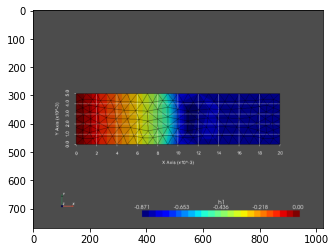

In [9]:
# Plot solution
import pyvista as pv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mesh = pv.read(wd+'/'+'out_level_116.vtk')
my_cmap = plt.cm.get_cmap("jet", 24)

# Take a screen shot
mesh.plot(
    screenshot=wd+'/myscreenshot.png',
    show_grid=True,
    show_edges=True,
    cpos="xy",
    scalars="h1", 
    smooth_shading=True, 
    cmap=my_cmap)

# Print a screen shot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(wd+'/myscreenshot.png')
imgplot = plt.imshow(img)
plt.show()

In [10]:
!cd /host_home/Downloads && mkdir temp

In [11]:
!ls /host_home/Downloads/temp

In [12]:
removereplace = 0
temp = input('Remove and replace files from the temp folder? 1 = yes, 0 = no    ')

Remove and replace files from the temp folder? 1 = yes, 0 = no    1


In [13]:
removereplace = int(temp)

In [14]:
if removereplace == 1:
    !rm /host_home/Downloads/temp/out*
    !cp {wd}/out*vtk /host_home/Downloads/temp

rm: cannot remove '/host_home/Downloads/temp/out*': No such file or directory


In [15]:
!ls /host_home/Downloads/temp

out_level_0.vtk    out_level_24.vtk   out_level_380.vtk  out_level_52.vtk
out_level_100.vtk  out_level_240.vtk  out_level_384.vtk  out_level_520.vtk
out_level_104.vtk  out_level_244.vtk  out_level_388.vtk  out_level_524.vtk
out_level_108.vtk  out_level_248.vtk  out_level_392.vtk  out_level_528.vtk
out_level_112.vtk  out_level_252.vtk  out_level_396.vtk  out_level_532.vtk
out_level_116.vtk  out_level_256.vtk  out_level_4.vtk	 out_level_536.vtk
out_level_12.vtk   out_level_260.vtk  out_level_40.vtk	 out_level_540.vtk
out_level_120.vtk  out_level_264.vtk  out_level_400.vtk  out_level_544.vtk
out_level_124.vtk  out_level_268.vtk  out_level_404.vtk  out_level_548.vtk
out_level_128.vtk  out_level_272.vtk  out_level_408.vtk  out_level_552.vtk
out_level_132.vtk  out_level_276.vtk  out_level_412.vtk  out_level_556.vtk
out_level_136.vtk  out_level_28.vtk   out_level_416.vtk  out_level_56.vtk
out_level_140.vtk  out_level_280.vtk  out_level_420.vtk  out_level_560.vtk
out_level_144.vtk  out_level_2

The vtk files can now be found in **Download/temp** folder on your computer and can be post processed with Paraview as explained in the following section.

# Visualizing the output

Assuming paraView is installed on your machine, open paraView and load the file **out_level***


`
File -> Open... -> go to the output file directory, then select the out_level* -> OK -> Apply (under Properties)
`

> If some steps later on do not seem to work, remember to be in the correct view and press **Apply**

The pressure head $h$ is output as **h1**, therefore change **GLOBAL_ID** to **h1** in the dropdown option.

<img src="http://mofem.eng.gla.ac.uk/mofem/html/output12.png" width="800">

Press the play button to start playing through the time snapshots, for example, the snapshot at the step 106 looks 

<img src="http://mofem.eng.gla.ac.uk/mofem/html/output13.png" width="800">

To plot the time profile of the horizontal line through the mid-section of the rectangle 

`
Plot Over Line icon -> In Properties select X Axis button -> in Series Parameters field select only **h1** 
`

Then you get

<img src="http://mofem.eng.gla.ac.uk/mofem/html/overline.png" width="800">

To Plot the time profile of a given point, first close the **LineChartView1** window and delete the **PlotOverLine1** in the **Pipeline Browser window**. Then press on
the **Select Points On (d)** icon at the top the **RenderView1** window to trigger the selection

`
hover over the domain and select a point somewhere in the middle -> press the Plot Selection Over Time button -> select Apply -> unselect all variables except h1 in the Propertties window
`

<img src="http://mofem.eng.gla.ac.uk/mofem/html/overtime.png" width="800">

paraView is a powerful visualisation and analysis tool. It has reach functionalities, you may play around to get a some understanding of it.

## Exercise 

- **Estimating speed of the front of pressure head**. To do this, you need a grid over in the **RenderView** of **VTK**, in which the output is lying inside it.
   and then put the **Time** at a certain point say 56. You can get the grid in the following way, on the paraView page with the output loaded, in the **Properties** view under 
   **Annotations** check **Axis Grid** and press **Edit** button next to it. A dialogue box appears, in it press the gear as shown, 
   
   <img src="http://mofem.eng.gla.ac.uk/mofem/html/dialogue2.png" width="400">
   
   and on the appearing dialogue box check **Show Grid** button and press the gear as shown,  
   
   <img src="http://mofem.eng.gla.ac.uk/mofem/html/dialogue3.png" width="400">
   
   now on the final dialogue box appearing check **Show Grid**, **Show Edges** and **Show Ticks**, 
   
   <img src="http://mofem.eng.gla.ac.uk/mofem/html/dialogue4.png" width="400">
   
   finally press **Apply** -> **OK** then close the dialogue box.  
   
   <img src="http://mofem.eng.gla.ac.uk/mofem/html/grid.png" width="800">
   
   (since the **save_every_nth_step**  is set at 4, it implies that output 56 means t = 56X4Xdt where dt is the time step size) then for example h1 = -0.5 is
   roughly at 0.008. Hence we effectively say that at t = 242Xdt the speed is 0.008/(242Xdt). Do this at various time steps and record the speeds. Now do the speed
   test for different values of saturated_conductivity $K_s$. And observe that how the size of $K_s$ influences the speed.

- **Add more feature to the geometry**. For example, a geometry consisting of two rectangles separated by an angle $\pi/3$, as shown

<img src="http://mofem.eng.gla.ac.uk/mofem/html/two_rec.png" width="800">

and the geo file **two_rec.geo** is 

`
// Gmsh project created on Mon Jan 27 21:51:41 2020
lx = 0.02;    
ly = 0.005;
SetFactory("OpenCASCADE");
`

`
Rectangle(1) = {0, 0, 0, lx, ly, 0};
Rotate {{0, 0, 1}, {lx, ly/2, 0}, Pi/3} { Duplicata { Surface{1}; }} 
BooleanUnion { Surface{1}; } { Surface{2}; }
Recursive Delete { Surface{1}; Surface{2}; }
`

`
Physical Curve("ESSENTIAL", 1) = {8};
Physical Surface("INITIAL", 2) = {3};
`
   
   Understand what each line is about. Create the corresponding mesh and execute the code with it. Now create a geometry such as this
   
   <img src="http://mofem.eng.gla.ac.uk/mofem/html/star_geo.png" width="800">
   
   Create a mesh with it and run the code using the mesh. 
